# Simulating a multi-mode stochastic hybrid system

In [64]:
import torch
import attr
from torch.distributions import Exponential
import torch.nn as nn

import matplotlib.pyplot as plt
from torchdyn.numerics import odeint_hybrid

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We define a callback for each type of event present in our hybrid multi-mode system. For more details on simulation of stochastic events in Neural ODEs, see [1](https://arxiv.org/abs/2106.04165), [2](https://arxiv.org/abs/2011.03902). For a more complete treatment on stochastic hybrid systems (SHSs), see [here](https://www.sciencedirect.com/science/article/abs/pii/S0947358010706889).

In [65]:
@attr.s
class EventCallback(nn.Module):
    def __attrs_post_init__(self):
        super().__init__()

    def check_event(self, t, x):
        raise NotImplementedError

    def jump_map(self, t, x):
        raise NotImplementedError

        
@attr.s
class StochasticEventCallback(nn.Module):
    def __attrs_post_init__(self):
        super().__init__()
        self.expdist = Exponential(1)
    
    def initialize(self, x0):
        self.s = self.expdist.sample(x0.shape[:1])
        
    def check_event(self, t, x):
        raise NotImplementedError

    def jump_map(self, t, x):
        raise NotImplementedError


@attr.s
class TCPEvent1(StochasticEventCallback):
    def check_event(self, t, x):
        w, s, q, λ = x[...,:1], x[...,1:2], x[...,2:3], x[...,3:4]
        ev1 = (λ - self.s >= 0).bool()
        ev2 = (q == 0).bool()
        return torch.logical_and(ev1, ev2)

    def jump_map(self, t, x):
        self.s = self.expdist.sample(x.shape[:1])
        w, s, q, λ = x[...,:1], x[...,1:2], x[...,2:3], x[...,3:]
        wj, sj = w0e1 + torch.zeros_like(w), torch.zeros_like(s)
        qj, λj = 1+torch.zeros_like(q), torch.zeros_like(λ)
        return torch.cat([wj, sj, qj, λj], 1)
    
@attr.s
class TCPEvent2(StochasticEventCallback):
    def check_event(self, t, x):
        w, s, q, λ = x[...,:1], x[...,1:2], x[...,2:3], x[...,4:5]
        ev1 = (λ - self.s >= 0).bool()
        ev2 = (q == 1).bool()
        return torch.logical_and(ev1, ev2)

    def jump_map(self, t, x):
        self.s = self.expdist.sample(x.shape[:1])
        w, s, q, λ = x[...,:1], x[...,1:2], x[...,2:3], x[...,3:]
        wj, sj = torch.zeros_like(w), torch.zeros_like(s)
        qj, λj = torch.zeros_like(q), torch.zeros_like(λ)
        return torch.cat([wj, sj, qj, λj], 1)
    
@attr.s
class TCPEvent3(StochasticEventCallback):
    def check_event(self, t, x):
        w, s, q, λ = x[...,:1], x[...,1:2], x[...,2:3], x[...,4:5]
        ev1 = (λ - self.s >= 0).bool()
        ev2 = (q == 1).bool()
        return torch.logical_and(ev1, ev2)

    def jump_map(self, t, x):
        self.s = self.expdist.sample(x.shape[:1])
        w, s, q, λ = x[...,:1], x[...,1:2], x[...,2:3], x[...,3:]
        wj, sj = w / 2, s
        qj, λj = 2+torch.zeros_like(q), torch.zeros_like(λ)
        return torch.cat([wj, sj, qj, λj], 1)
    
@attr.s
class TCPEvent4(StochasticEventCallback):
    def check_event(self, t, x):
        w, s, q, λ = x[...,:1], x[...,1:2], x[...,2:3], x[...,4:5]
        ev1 = (λ - self.s >= 0).bool()
        ev2 = (q == 2).bool()
        return torch.logical_and(ev1, ev2)

    def jump_map(self, t, x):
        self.s = self.expdist.sample(x.shape[:1])
        w, s, q, λ = x[...,:1], x[...,1:2], x[...,2:3], x[...,3:]
        wj, sj = w / 2, s
        qj, λj = 2+torch.zeros_like(q), torch.zeros_like(λ)
        return torch.cat([wj, sj, qj, λj], 1)
    
@attr.s
class TCPEvent5(StochasticEventCallback):
    def check_event(self, t, x):
        w, s, q, λ = x[...,:1], x[...,1:2], x[...,2:3], x[...,4:5]
        ev1 = (λ - self.s >= 0).bool()
        ev2 = (q == 2).bool()
        return torch.logical_and(ev1, ev2)

    def jump_map(self, t, x):
        self.s = self.expdist.sample(x.shape[:1])
        w, s, q, λ = x[...,:1], x[...,1:2], x[...,2:3], x[...,3:]
        wj, sj = torch.zeros_like(w), torch.zeros_like(s)
        qj, λj = torch.zeros_like(q), torch.zeros_like(λ)
        return torch.cat([wj, sj, qj, λj], 1)


We then define the system dynamics. Depending on the mode, the vector field changes. The mode is indicated with an aux. variable.

In [ ]:
w0e1 = 0.693
τoff = 3
RTT = 1
nack = 2
pdrop = 0.05
l2 = 0.693
k = 20
class TCP(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, t, x):
        w, s, q = x[...,:1], x[...,1:2], x[...,2]
        nel_q0, nel_q1, nel_q2 = len(x[q==0]), len(x[q==1]), len([q==2])
        
        sol = []
        if nel_q0 > 0:
            q0_dx = torch.zeros_like(x[q==0][...,:2])
            sol.append(q0_dx)
            
        if nel_q1 > 0:
            q1_dw = (l2 * w[q==1]) / (nack * RTT)
            q1_ds = w[q==1] / RTT
            q1_dx = torch.cat([q1_dw, q1_ds], 1)
            sol.append(q1_dx)
            
        if nel_q2 > 0:
            q2_dw = torch.ones_like(w[q==2]) / (nack * RTT)
            q2_ds = w[q==2] / RTT
            q2_dx = torch.cat([q2_dw, q2_ds], 1)
            sol.append(q2_dx)
        dx = torch.cat(sol, 0)
        
        
        
        # lambda dynamics
        λ = x[...,3:]
        dλ1 = 1 / τoff * torch.ones_like(λ[...,:1]) # ev1
        dλ2 =  w / (k*RTT) # ev1
        dλ3 = pdrop * w / RTT # ev1
        dλ4 = pdrop * w / RTT # ev1
        dλ5 = w / (k*RTT) # ev1    
        dλ = torch.cat([dλ1, dλ2, dλ3, dλ4, dλ5], 1)
        return torch.cat([dx, torch.zeros_like(x[...,-1:]), dλ], 1)

### 3-mode TCP

The system (and diagram) is taken from [this detailed work on TCP modeling](https://web.ece.ucsb.edu/~hespanha/published/shs-ijhs04.pdf).

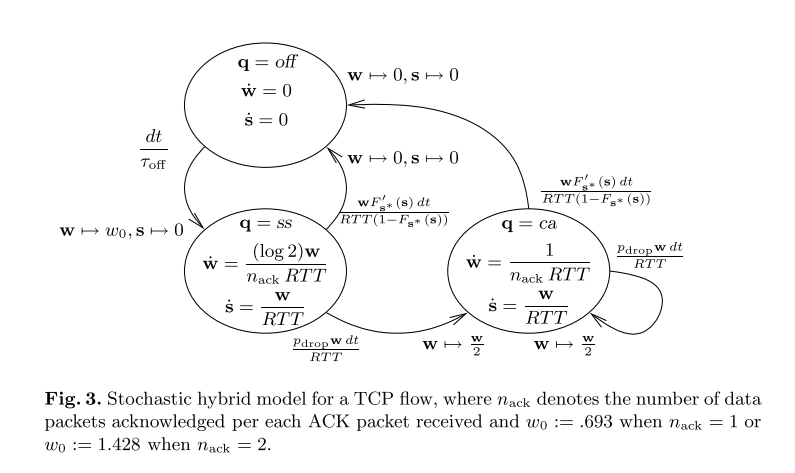

* $\tt off$: off mode, flow of packets inactive, $w = s = 0$
* $\tt ss$: slow start 
* $\tt ca$: congestion avoidance

In [83]:
f = TCP()

x0 = torch.tensor([[0., 0., 0]])

# append zeroed initial intensity states, one for each event
x0 = torch.cat([x0, torch.zeros(x0.shape[0], 5)], 1)

callbacks = [TCPEvent1(), TCPEvent2(), TCPEvent3(), TCPEvent4(), TCPEvent5()]
for cb in callbacks: cb.initialize(x0)
t_eval, sol = odeint_hybrid(f, x0, t_span=torch.linspace(0, 100, 2000), j_span=10, callbacks=callbacks, event_tol=1e-4, solver='tsit5', atol=1e-5, rtol=1e-5)

Text(0.5, 0, '$t$')

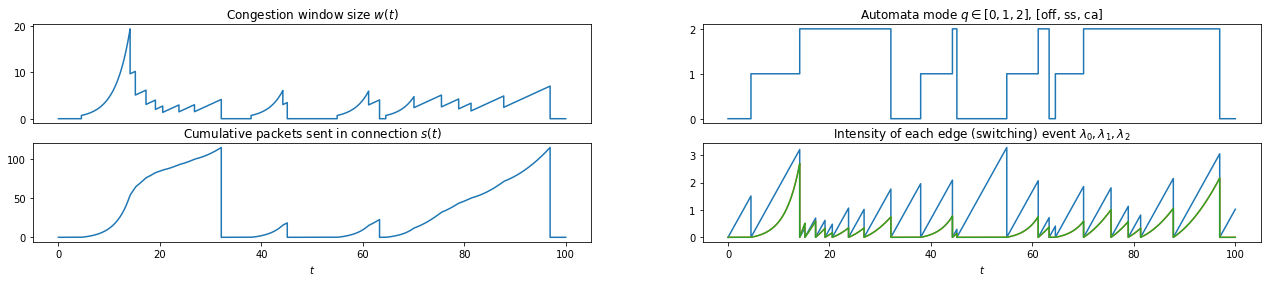

In [84]:
fig = plt.figure(figsize=(22,4))
ax = fig.add_subplot(221); ax.plot(t_eval, sol.detach()[:,:,0]); 
ax.set_title('Congestion window size $w(t)$'); ax.set_xticks([])

ax = fig.add_subplot(223); ax.plot(t_eval, sol.detach()[:,:,1]);
ax.set_title('Cumulative packets sent in connection $s(t)$'); ax.set_xlabel('$t$')


ax = fig.add_subplot(222); ax.plot(t_eval, sol.detach()[:,:,2]);
ax.set_title('Automata mode $q\in[0,1,2]$, [off, ss, ca]'); ax.set_xticks([])

ax = fig.add_subplot(224); ax.plot(t_eval, sol.detach()[:,0,3:6]);
ax.set_title('Intensity of each edge (switching) event $\lambda_0, \lambda_1, \lambda_2$'); ax.set_xlabel('$t$')